In [ ]:
using Flux, Turing, StatsPlots

In [ ]:
@model function gdemo(x, y)
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))
    x ~ Normal(m, sqrt(s))
    y ~ Normal(m, sqrt(s))
end


In [ ]:
# run sampler
chn = sample(gdemo(1.5,2), HMC(0.1, 5), 1000)

In [ ]:
describe(chn)

In [ ]:
p = plot(chn)


In [ ]:
using Plots, Flux, Zygote

In [ ]:
x = 1:10;
a, b = rand(2);

y = a * x .+ b + rand(10);

plot(x,y)

In [ ]:
model(a,b) = a * x .+ b;

loss(x,y) = sum((model(a,b) - y).^2);
#loss(a,b)


In [ ]:
gradient(() -> 3x, x)

In [ ]:
W = rand(2,5); b = rand(2);

In [ ]:
linear(x) = W * x .+ b;

In [ ]:
gradient(x -> 3x^2 + 2x + 1, 5)

We can diff wrt many params at once by passing them in as Arrays within Dicts.

In [ ]:
linear(theta, x) = theta[:W] * x .+ theta[:b];
x = rand(5);
theta = Dict(:W => rand(2,5), :b => rand(2)); # index as theta[:W]

grads = gradient(theta -> sum(linear(theta,x)), theta)[1]; # diff w.r.t theta (both vars included)
print(grads[:b])
print(grads[:W])



# Linear regressions

Let's try to just do a simple linear regression example.

In [ ]:
x = -10:10;
theta_exact = [2.31, 4.44];
y = theta_exact[1] * x .+ theta_exact[2] + 5*2*(rand(21).-0.5);
theta
plot(x,y)

In [ ]:
linear(theta,x) = theta[1] * x .+ theta[2];

loss(theta) = sum( (y .- linear(theta,x)).^2 );

In [ ]:
num_iters = 400;
loss_trace = []

for i = 1:num_iters
    grads = gradient( theta -> loss(theta), theta)[1]
    theta = theta .- 0.001 .* grads
    push!(loss_trace, loss(theta))
end


In [ ]:
plot(loss_trace)

In [ ]:
theta

In [ ]:
theta_exact

# Neural network example

In [104]:
using MLDatasets, Zygote, RDatasets, Plots, Statistics
using Base

In [74]:
iris = dataset("datasets", "iris"); 
# restrict to only two cases
iris = iris[(iris[:, :Species] .== "setosa").|(iris[:,:Species] .== "virginica"), :];

num_samples = size(iris)[1];

In [92]:
X = hcat(Array(iris[:,1:2]), ones(num_samples,1)); # append bias column
Y = Array(iris[:,5]);

label_map = Dict(label => idx for (idx, label) in enumerate(unique(Y)))
Y_idx = [ label_map[y]-1 for y in Y ];

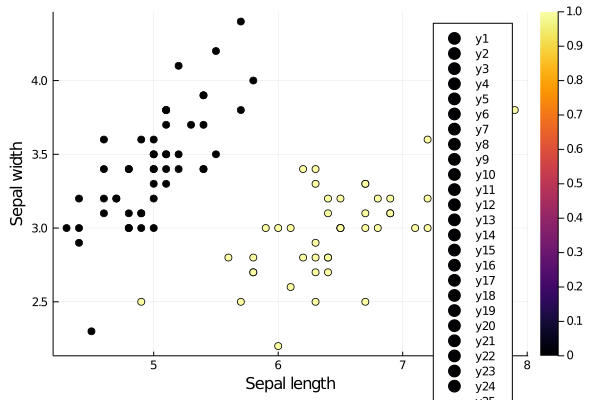

In [93]:
plt = plot(xguide = "Sepal length", yguide = "Sepal width")

for (idx, label) in enumerate(Y_idx)
    scatter!(plt, [X[idx,1]], [X[idx,2]], marker_z=label)
end

#scatter!(plt, X[:,1], X[:,2], marker_z=Y_idx)

display(plt)

In [94]:
mu_1, mu_2 = mean(X[:,1]), mean(X[:,2]);
sig_1, sig_2 = std(X[:,1]), std(X[:,2]);

In [95]:
X[:,1] = (X[:,1] .- mu_1) ./ sig_1;
X[:,2] = (X[:,2] .- mu_2) ./ sig_2;

Since this is a binary classification problem, we only need to predict a single number for each sample: the probability $p$ of the input belonging to class 1. 

In [96]:
W = rand(3); # single layer weights

X * W

100-element Array{Float64,1}:
  0.1918731393213176 
 -1.0038487771183513 
 -0.7137469410189103 
 -0.9932170951232218 
  0.3369240573710385 
  1.2425441377112671 
 -0.356435486892175  
 -0.08759701478299337
 -1.5521574033318442 
 -0.7915882410413354 
  0.818023065557236  
 -0.2220162508375843 
 -1.0710583951456472 
  ⋮                  
 -0.2645429788181026 
  0.5526041195045717 
  0.41818488344998084
  0.5526041195045717 
 -1.0357438231037404 
  0.6976550375542918 
  0.8427059556040117 
  0.20592434737296494
 -1.1242168051212955 
  0.07150511131837411
  0.7189184015445509 
 -0.33175259684539776

In [97]:
function sigmoid(Z)
    return(1 ./ (1 .+ exp.(-Z)))
end;

# sigmoid.( X * W )

In [112]:
loss(W) = - sum(Y_idx .* log.(sigmoid(X * W)) + (1 .- Y_idx) .* log.(1 .- sigmoid(X * W) )) / num_samples ;

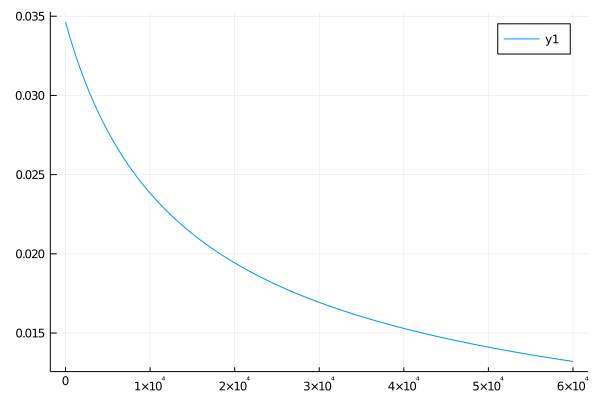

In [130]:
num_iters = 6e4;
loss_trace = []

for i = 1:num_iters
    grads = gradient( W -> loss(W), W)[1]
    #println(grads)
    W = W .- 0.01 .* grads
    push!(loss_trace, loss(W))
end

plot(loss_trace)

In [131]:
W

3-element Array{Float64,1}:
  7.216103605920076 
 -3.5868906327910786
  1.2569812536036171

Recall that the log reg model is $$ \hat{y} = \frac{1}{1+\exp\left(-W^T X \right)}$$ If we make our classification decision at $ y = \frac{1}{2} $, then we can write this as $$ \frac{1}{2} = \frac{1}{1+\exp\left(-W^T X^* \right)} $$ which, upon rearranging, becomes $$ 0 = W^T X^* = w_1 x_1 + w_2 x_2 + w_3 $$ which we can write (and plot) in the familiar form $$ x_2 = - \frac{w_1}{w_2} x_1 - \frac{w_3}{w_2} $$

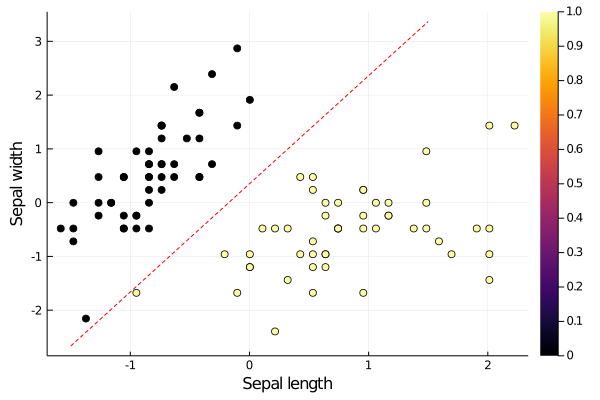

In [143]:
plt = plot(xguide = "Sepal length", yguide = "Sepal width")

for (idx, label) in enumerate(Y_idx)
    scatter!(plt, [X[idx,1]], [X[idx,2]], marker_z=label, label=false)
end

t=-1.5:0.1:1.5;
y_mod = - (W[1]/W[2]) * t .- (W[3]/W[2])
plot!(t,y_mod, label=false, linestyle=:dash, linecolor=:red)

display(plt)